# 15分足データの基本分析

- 上昇確率

## 結果・考察
- 30分足では、全体での上昇確率46%、不変確率11%、下落確率44%
    - 15分足よりもう少し不変確率が下がった。
- 1年毎で見ると、15分足と同様に2003～2006は値動きが小さい。

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed
from functools import reduce

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# データ読み込み

In [4]:
# 生データ
sp_dir = 'data/e-mini-sp500-200530'
df_sp_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-30min.csv')

# 月次データ（1年ごとの価格変化を見るため）
df_spm_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-monthly.csv')

In [6]:
df_sp_raw

,Date,Time,Open,High,Low,Close,Up,Down,FastAvg,SlowAvg
0,09/11/1997,05:00,1071.75,1071.75,1069.25,1069.25,5,0,0.00,0.00
1,09/11/1997,06:00,1068.75,1068.75,1068.75,1068.75,1,0,0.00,0.00
2,09/11/1997,08:30,1068.25,1068.25,1066.50,1066.50,13,0,0.00,0.00
3,09/11/1997,09:00,1066.00,1066.50,1063.00,1064.25,43,0,0.00,0.00
4,09/11/1997,09:30,1065.25,1067.00,1064.25,1067.00,28,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
252580,08/13/2020,18:30,3368.75,3372.00,3368.50,3370.25,1117,1166,3369.00,3369.61
252581,08/13/2020,19:00,3370.25,3373.25,3370.25,3372.50,1154,746,3370.75,3369.31
252582,08/13/2020,19:30,3372.50,3376.00,3372.50,3375.00,2052,1320,3372.58,3369.28
252583,08/13/2020,20:00,3374.75,3377.25,3374.50,3375.75,1961,1851,3374.42,3370.11


# 分析用データ作成

In [7]:
df = df_sp_raw.copy()

# DateTime列を追加
df['DT'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))

# 値動き（終値 - 始値）列を追加
df['CODiff'] = df['Close'] - df['Open']

# 年の列を追加
df['year'] = df['DT'].map(lambda d: d.year)

# 年の順序付け
year_type = CategoricalDtype(categories=range(df['year'].min(), df['year'].max()+1), ordered=True)
df['year'] = df['year'].astype(year_type)

In [8]:
# 上昇、不変、下落
df['isUp'] = df['CODiff'] > 0
df['isFlat'] = df['CODiff'] == 0
df['isDown'] = df['CODiff'] < 0

### 年次データの作成（月次データを1年ごとに平均する）

In [9]:
dfm = df_spm_raw.copy()
dfm['DT'] = (dfm['Date'] + '-' + dfm['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
dfm['year'] = dfm['DT'].map(lambda x: x.year)

dfm_by_year = dfm.groupby('year').mean()

# 全期間での30分足データの上昇確率

In [10]:
print(f"P(UP) = {df['isUp'].sum()} / {df.shape[0]} = {df['isUp'].sum() / df.shape[0] * 100}%")
print(f"P(FLAT) = {df['isFlat'].sum()} / {df.shape[0]} = {df['isFlat'].sum() / df.shape[0] * 100}%")
print(f"P(DOWN) = {df['isDown'].sum()} / {df.shape[0]} = {df['isDown'].sum() / df.shape[0] * 100}%")
df['isUp'].sum() + df['isFlat'].sum() + df['isDown'].sum() == df.shape[0]

P(UP) = 114990 / 252585 = 45.52526872142052%
P(FLAT) = 27697 / 252585 = 10.965417582200052%
P(DOWN) = 109898 / 252585 = 43.50931369637944%


True

# 1年ごとの上昇確率推移

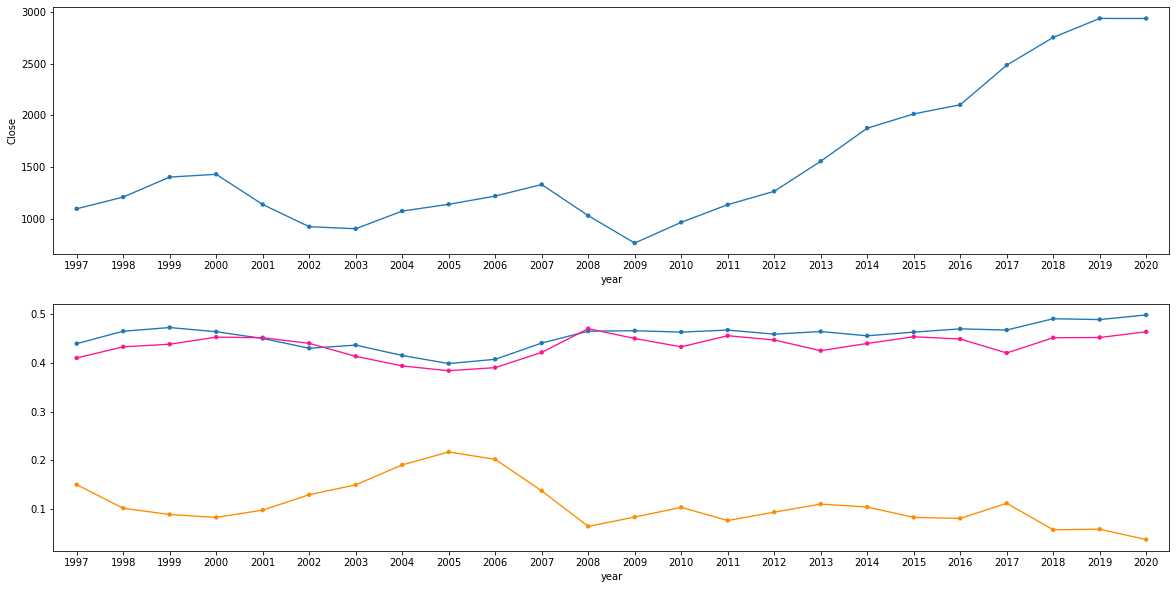

In [11]:
df_by_year = df.groupby('year')[['isUp', 'isFlat', 'isDown']].sum()
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.pointplot(dfm_by_year.index, dfm_by_year['Close'], scale=0.5, ax=ax[0])
sns.pointplot(df_by_year.index, df_by_year['isUp'] / df['year'].value_counts().sort_index(), scale=0.5, ax=ax[1])
sns.pointplot(df_by_year.index, df_by_year['isFlat'] / df['year'].value_counts().sort_index(), scale=0.5, ax=ax[1], color='darkorange')
sns.pointplot(df_by_year.index, df_by_year['isDown'] / df['year'].value_counts().sort_index(), scale=0.5, ax=ax[1], color='deeppink')